# ActEESummary (last update: 03-May-2019)
---
`ActEESummary` generates summary information from the accelerometer data during the first 7 days.


In [3]:
using PyCall
pygui(:tk)
using PyPlot, DataFrames, Dates, StatsBase, CSV, Latexify
include("../src/ActEEDisplay.jl")
include("../src/ActStatData.jl")

using .ActEEDisplay

In [8]:
# List of visit directories
listDir = ["/../data/Baseline Visit Data/";
           "/../data/32 Week Gestation Data/";
           "/../data/6 Week PP Data/";
           "/../data/6 Months PP Data/";
           "/../data/12 Months PP Data/"]

# Get the data list files from the directory myDir
# Get the path of the directory 
myDir = abspath(string(@__DIR__,listDir[1]));

# # Get the data list files from the directory myDir
# (actFiles, bioFiles) = ActStatData.filesNoNaN(myDir);
(myData, myHeader) = ActStatData.filesNoNaN(myDir);
numFile = 3;

There is no missing (i.e. NA) data log in the following directory:
C:\git\senresearch\AccelerometerDataProcessing\data\Baseline Visit Data\


In [10]:
myActHeader = myDir*myHeader[numFile]
# Get any file and show columns of the data frame structure
df = ActStatData.readActivity(myDir*myData[numFile]);
describe(df)

,variable,mean,min,median,max
,Symbol,Union…,Any,Any,Any
1,Day,6.46647,1,6.0,12
2,ElapsedSeconds,472530.0,180,472530.0,944880
3,DateTime,,2017-05-22T11:59:00,2017-05-27T23:11:30,2017-06-02T10:24:00
4,ActivityCounts,87.9847,0,0.0,3346
5,Steps,3.83545,0,0.0,125
6,EnergyExpenditure,0.00336739,0.0,0.0,0.063
7,ActivityIntensity,1.25861,1,1.0,3


In [12]:
# Get the weight from the bio file
    dfB = ActStatData.readActivity(myActHeader)
    wght = parse(Float64, dfB[6,2]);

In [14]:
colNum = 6;
myData[3][1:end-4];

In [23]:
completeNumDays = 7
# Select the first 'completeNumDays' days
    df = df[df[!,:Day] .< completeNumDays+1, :];
# Estimate the total amount of calories burnt per day
    dfSumAct = groupby(df, :Day) 
    dfSumAct= combine(dfSumAct, :EnergyExpenditure => (x->sum(x.*wght)) => :ActCalPerDiem)
# Create vectors containing daily calories burnt by physical activity
    sumAEE = dfSumAct[:,:ActCalPerDiem]
    sumAEE = collect(Iterators.flatten(transpose(sumAEE)));

In [27]:
# Calculate count value for each level of activity (Light, Moderate, Vigorous)

    weekIntensity = zeros(completeNumDays, 4, 2)
    for i = 1:completeNumDays
        dtmp = df[df[!,:Day] .== i, :];
        tmp =  Int64.(collect(Iterators.flatten(dtmp[:, :ActivityIntensity])));
        tmp = sort(tmp);
        if length(counts(tmp)) < 4
            if length(counts(tmp)) < 3
                if length(counts(tmp)) < 2
                    weekIntensity[i,1,:] = [counts(tmp) counts(tmp).*100/sum(counts(tmp))];
                else
                    weekIntensity[i,1:2,1:2] = [counts(tmp) counts(tmp).*100/sum(counts(tmp))];
                end # if
            else
                weekIntensity[i,1:3,1:2] = [counts(tmp) counts(tmp).*100/sum(counts(tmp))];
            end # if
        else
            weekIntensity[i,:,:] = [counts(tmp) counts(tmp).*100/sum(counts(tmp))];
        end # if
    end # for

In [28]:
# Get timing of the first and last epoch in order to estimate the
    # total number of days.
    myStartTime = df[1,3];
    myFinishTime = df[end,3];
    # Get the total number of seconds wearing the device
    totalWearTime = convert(Float64,Dates.value(Dates.Second((myFinishTime-myStartTime)))); #in seconds
    completeNumDays = Int(floor(totalWearTime/86400)); # number of day with full 24 hours

    # Get the exact date of each day of the week (e.g. Mon, 22 May 2017)
    durationDay = collect(Dates.format.(myStartTime:Day(1):myFinishTime, "e, dd u yyyy"))

7-element Vector{String}:
 "Mon, 22 May 2017"
 "Tue, 23 May 2017"
 "Wed, 24 May 2017"
 "Thu, 25 May 2017"
 "Fri, 26 May 2017"
 "Sat, 27 May 2017"
 "Sun, 28 May 2017"

In [29]:
df1 = DataFrame(Dates = durationDay, EnergyExpenditure = round.(sumAEE,
                                                                digits =1));

In [33]:
latexify(df1; env=:mdtable, adjustement =:c, latex = false) |> display; # display("text/latex", df1);
    weekIntensity = round.(weekIntensity, digits = 1);
    df2 = DataFrame(Dates = durationDay, Light = weekIntensity[:,1,2],
                                          Moderate = weekIntensity[:,2,2],
                                          Vigorous = weekIntensity[:,3,2])
latexify(df1; env=:mdtable, adjustement =:c, latex = false) |> display; # display("text/latex", df2);

|            Dates | EnergyExpenditure |
| ----------------:| -----------------:|
| Mon, 22 May 2017 |             226.8 |
| Tue, 23 May 2017 |             582.7 |
| Wed, 24 May 2017 |             665.8 |
| Thu, 25 May 2017 |             675.1 |
| Fri, 26 May 2017 |             378.4 |
| Sat, 27 May 2017 |             346.0 |
| Sun, 28 May 2017 |             281.5 |


|            Dates | EnergyExpenditure |
| ----------------:| -----------------:|
| Mon, 22 May 2017 |             226.8 |
| Tue, 23 May 2017 |             582.7 |
| Wed, 24 May 2017 |             665.8 |
| Thu, 25 May 2017 |             675.1 |
| Fri, 26 May 2017 |             378.4 |
| Sat, 27 May 2017 |             346.0 |
| Sun, 28 May 2017 |             281.5 |


In [34]:
ActEEDisplay.setPlotEEAct(durationDay, sumAEE, weekIntensity)

In [ ]:
ActEEDisplay.getPlotSumAEE(durationDay, sumAEE);


In [ ]:
df1 = DataFrame(Dates = durationDay, EnergyExpenditure = round.(sumAEE, digits =1));
weekIntensity = round.(weekIntensity, digits = 1);
df2 = DataFrame(Dates = durationDay, Sedentary = weekIntensity[:,1,2],
                                          Light = weekIntensity[:,2,2],
                                          Moderate = weekIntensity[:,3,2],
                                          Vigorous = weekIntensity[:,4,2]);
ActEEDisplay.setPlotEEAct(durationDay, sumAEE, weekIntensity)

#display("text/latex", df2);
latexify(df2; env=:mdtable, adjustement =:c, latex = false) |> display;

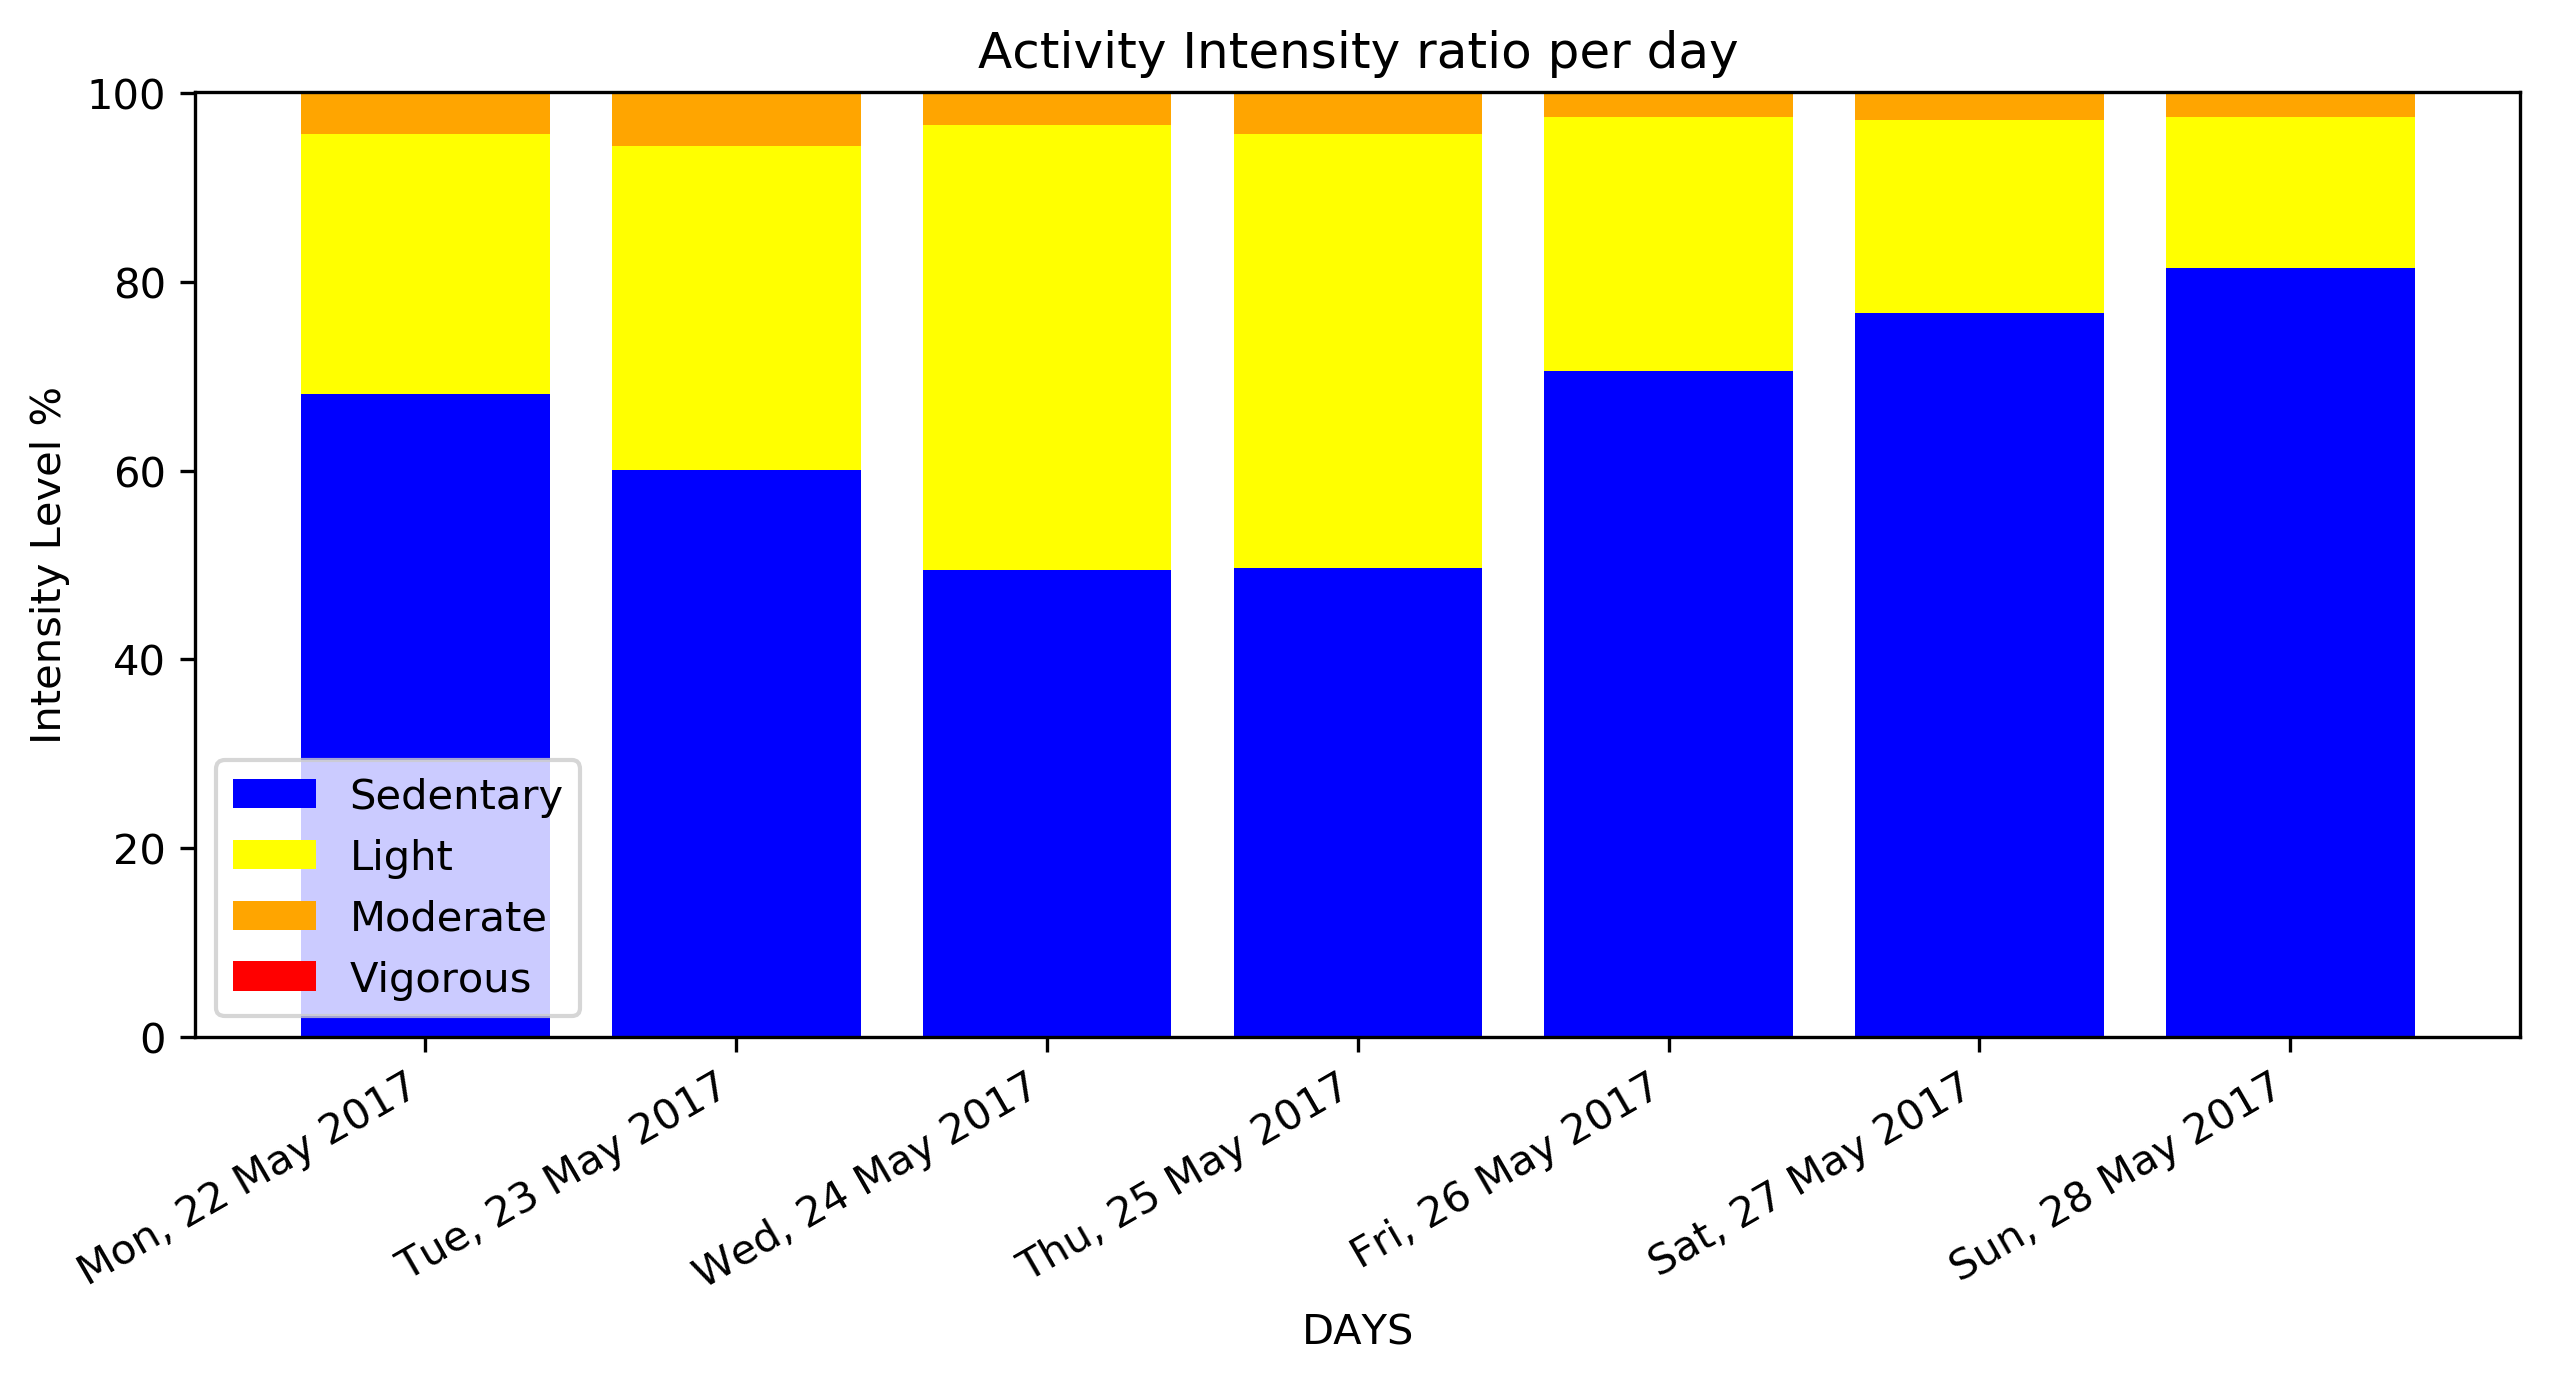

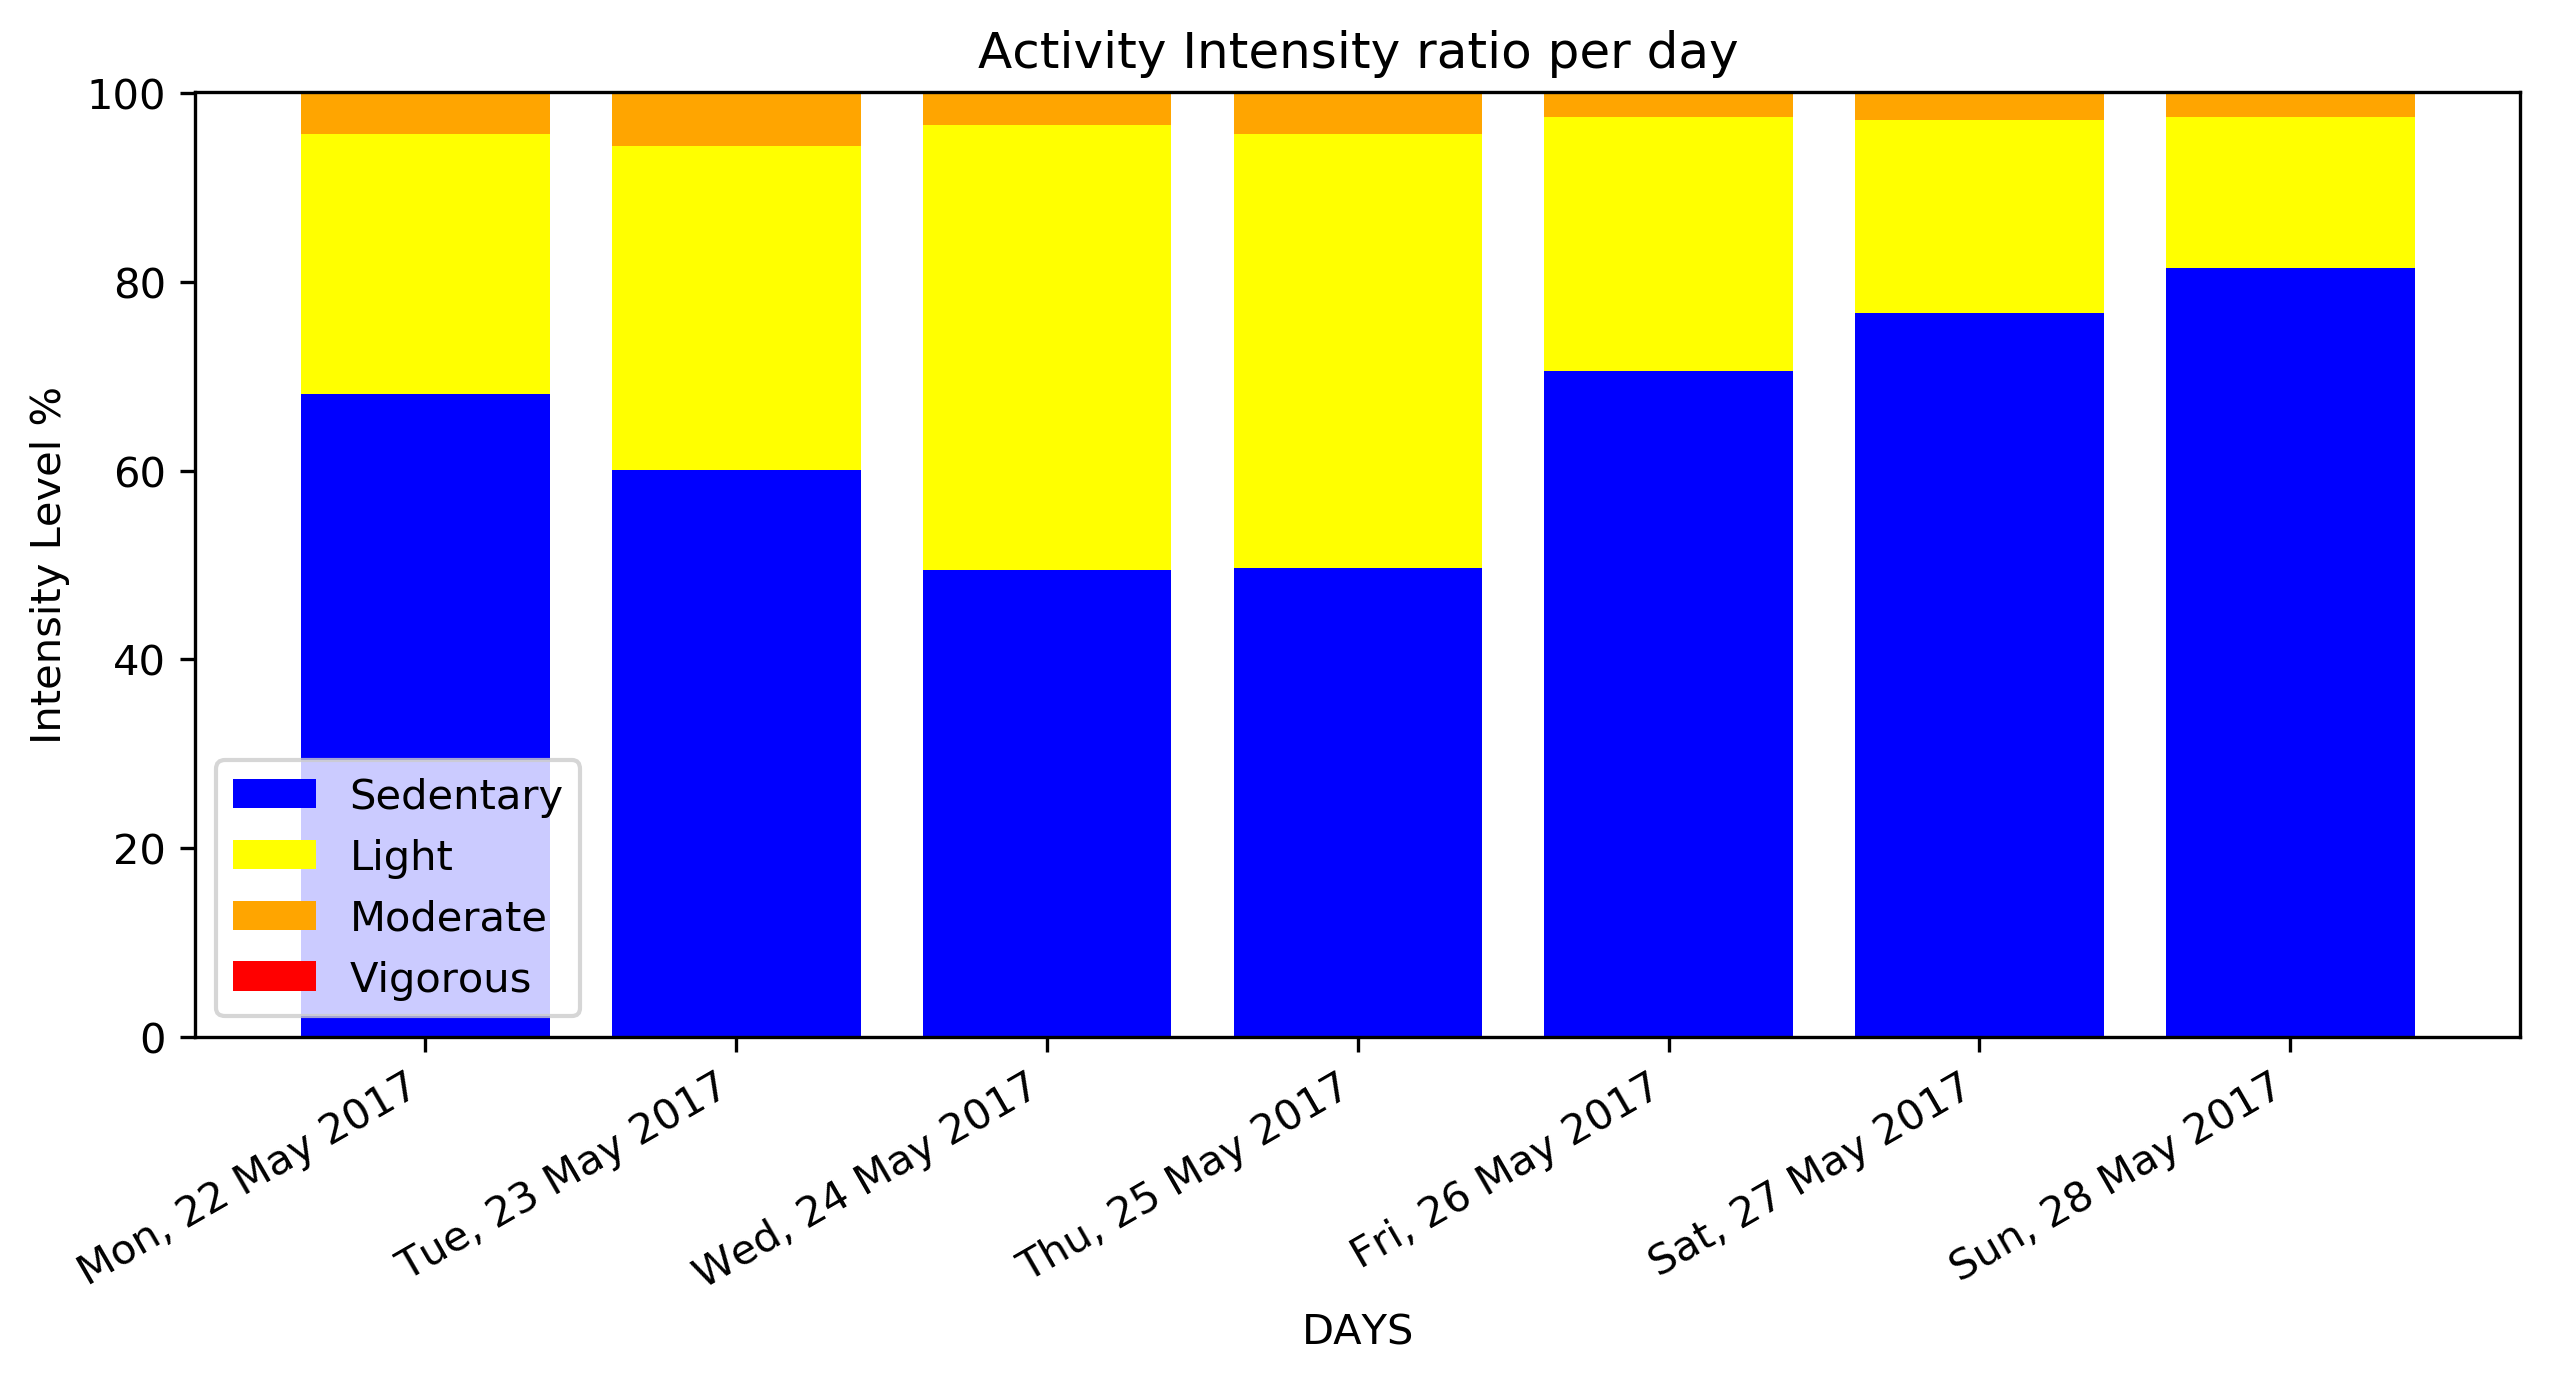

In [38]:
ActEEDisplay.getPlotIntensity(durationDay, weekIntensity)

In [ ]:
# Convert the column DateTime to DateTime type
df[:DateTime]=DateTime(df[:DateTime]);

In [25]:
#typeof(collect(Iterators.flatten(df[:,3])))
tmp = df[:,3]
typeof(df)


DataFrames.DataFrame

In [ ]:
dfTest = DataFrame();


""


In [ ]:
typeof(dfTest)

DataFrames.DataFrame

In [41]:
# Get timing of the first and last epoch in order to estimate the
# total number of days.
myStartTime = df[1,3];
myFinishTime = df[end,3];
# Get the total number of seconds wearing the device
totalWearTime = convert(Float64,Dates.value(Dates.Second((myFinishTime-myStartTime)))); #in seconds
completeNumDays = Int(floor(totalWearTime/86400)); # number of day with full 24 hours
[myStartTime,myFinishTime]

2-element Array{DateTime,1}:
 2017-05-22T11:59:00
 2017-06-02T10:24:00

In [43]:
[totalWearTime/86400, completeNumDays]

2-element Array{Float64,1}:
 10.934
 10.0  

In [46]:
[Dates.dayname(myStartTime), Dates.dayname(myFinishTime)]

2-element Array{String,1}:
 "Monday"
 "Friday"

In [52]:
# Reshape the vector in matrix such that each column corresponds to 24 hours of wearing time.
matActivity = reshape(df[1:completeNumDays*1440, colNum], 1440, completeNumDays); # 1440 min in 24 hours
matActivity = matActivity[:, :];


In [ ]:
dfB = ActStatData.readActivity(myDir*myHeader[3])

In [97]:
parse(Float64, dfB[6,2]);

In [96]:
sumAEE = sum(matActivity.*parse(Float64, dfB[6,2]), 1)
sumAEE = collect(Iterators.flatten(sumAEE.'));

In [95]:
durationDay = ["Day 1","Day 2", "Day 3", "Day 4", "Day 5", "Day 6", "Day 7", "Day 8", "Day 9", "Day 10"];

In [ ]:
ioff() # Interactive plotting OFF, necessary for inline plotting in IJulia

In [69]:
typeof(x)

Array{Int64,1}

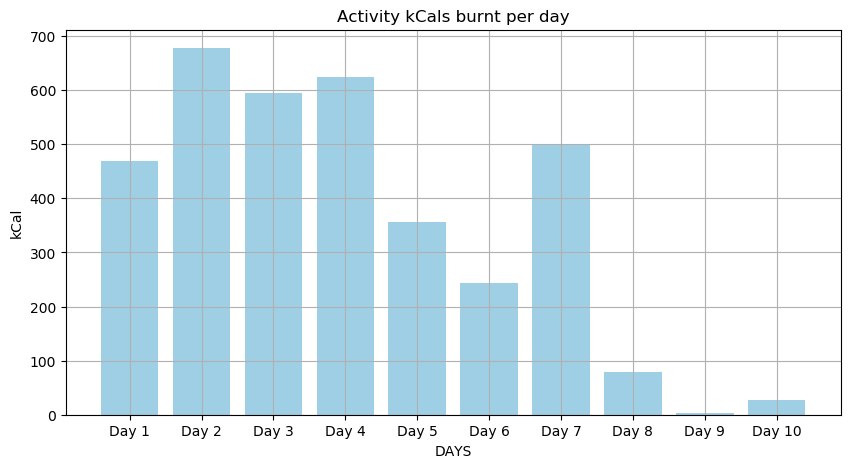

PyObject Text(24,0.5,u'kCal')

In [94]:
fig = figure("pyplot_barplot",figsize=(10,5))
b = bar(durationDay,sumAEE,color="#0f87bf",align="center",alpha=0.4);
axis("tight")
title("Activity kCals burnt per day")
grid("on")
xlabel("DAYS")
ylabel("kCal")

#gcf() # Needed for IJulia to plot inline

In [198]:
colNum = 7;
# Reshape the vector in matrix such that each column corresponds to 24 hours of wearing time.
matIntensity = reshape(df[1:completeNumDays*1440, colNum], 1440, completeNumDays); # 1440 min in 24 hours
matIntensity = matIntensity[:, :];

In [201]:

weekIntensity = zeros(completeNumDays, 3, 2)
for i = 1:completeNumDays
    tmp =  Int64.(collect(Iterators.flatten(matIntensity[:,i])));
    tmp = sort(tmp);
    if length(counts(tmp)) < 3
        if length(counts(tmp)) < 2
            weekIntensity[i,1,:] = [counts(tmp) counts(tmp).*100/sum(counts(tmp))];
        else
            weekIntensity[i,1:2,1:2] = [counts(tmp) counts(tmp).*100/sum(counts(tmp))];
        end
    else
        weekIntensity[i,:,:] = [counts(tmp) counts(tmp).*100/sum(counts(tmp))];
    end    
end

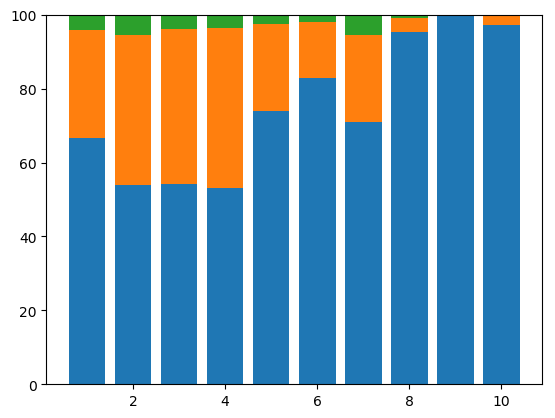

(PyObject <matplotlib.patches.Rectangle object at 0x7fb3e9128c50>, PyObject <matplotlib.patches.Rectangle object at 0x7fb3e9175450>, PyObject <matplotlib.patches.Rectangle object at 0x7fb3e9128fd0>, PyObject <matplotlib.patches.Rectangle object at 0x7fb3e9136410>, PyObject <matplotlib.patches.Rectangle object at 0x7fb3e9136750>, PyObject <matplotlib.patches.Rectangle object at 0x7fb3e9136ad0>, PyObject <matplotlib.patches.Rectangle object at 0x7fb3e9136e50>, PyObject <matplotlib.patches.Rectangle object at 0x7fb3e9142210>, PyObject <matplotlib.patches.Rectangle object at 0x7fb3e9142590>, PyObject <matplotlib.patches.Rectangle object at 0x7fb3e9142910>)

In [246]:
myWidth = 0.8;
numD = completeNumDays;
x = collect(1:numD)
bar(x, weekIntensity[1:numD,1,2] ,  width = myWidth)
bar(x, weekIntensity[1:numD,2,2], width = myWidth, bottom = weekIntensity[1:numD,1,2])
bar(x, weekIntensity[1:numD,3,2], width = myWidth, bottom = weekIntensity[1:numD,2,2]+weekIntensity[1:numD,1,2])

In [247]:
tmp = sort(Int64.(collect(Iterators.flatten(matIntensity[:]))));
actInt = [unique(tmp) counts(tmp) counts(tmp).*100/sum(counts(tmp))]

3×3 Array{Float64,2}:
 1.0  10768.0  74.7778 
 2.0   3228.0  22.4167 
 3.0    404.0   2.80556

In [ ]:
sum([unique(tmp) counts(tmp) counts(tmp).*100/sum(counts(tmp))],1)

In [ ]:
# Function roundPercent to round percentages values such that the sum is equal to 100%
# up      integer     round to up decimal
function roundPercent(up = 0)
    myVec = myVec * 10^up
    intVec = floor.(myVec)
    diffVec = myVec - intVec
    errSum = sum(intVec) - 100*10^up
    
end #function



In [149]:
#################
#  Create Data  #
#################
labels = ["Light";"Moderate";"Vigorous"]
colors = ["lightskyblue";"yellowgreen";"red"]
sizes = NaN*zeros(3)
explode = zeros(length(sizes))
explode[3] = 0 # Move slice 2 out by 0.1
sizes = [actInt[1,3]; actInt[2,3]; actInt[3,3]]
font = Dict("fontname"=>"Sans","weight"=>"semibold");

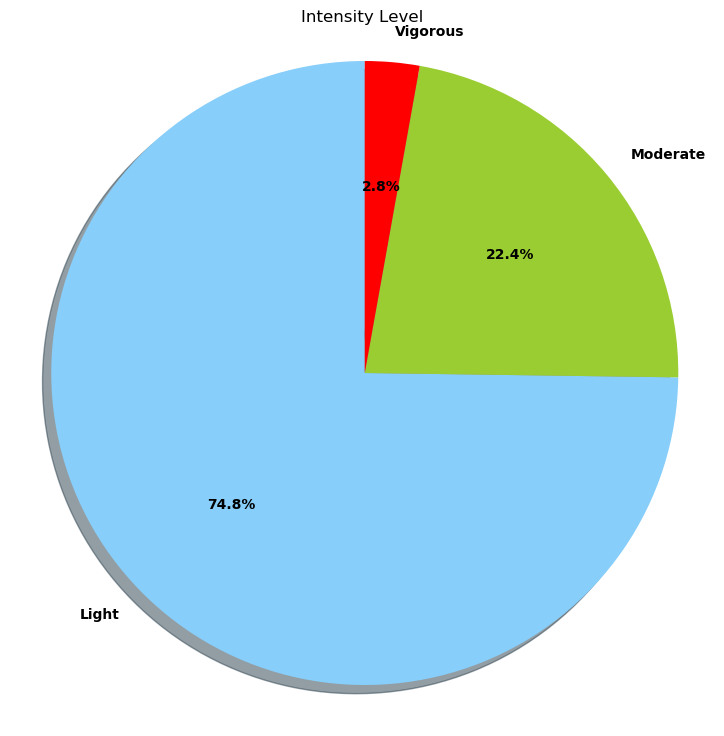

PyObject Text(0.5,1,u'Intensity Level')

In [153]:
###############
#  Pie Chart  #
###############
fig = figure("pyplot_piechart",figsize=(9,9))
p = pie(sizes,
        labels=labels,
        shadow=true,
        startangle=90,
        explode=explode,
        colors=colors,
        autopct="%1.1f%%",
        textprops=font)

axis("equal")
title("Intensity Level")
#gcf() # Needed for IJulia to plot inline